In [2]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib

print("numpy\t", np.__version__)
print("torch\t", torch.__version__)
print("matplotlib\t", matplotlib.__version__)

numpy	 1.26.4
torch	 2.3.0
matplotlib	 3.8.4


tensor([[-0.3389,  1.5841],
        [-0.7026, -3.1712],
        [ 0.7534,  0.4172]])
tensor([-2.0086, -4.9645, -1.9518])


(<Figure size 600x500 with 2 Axes>, <Axes: >)

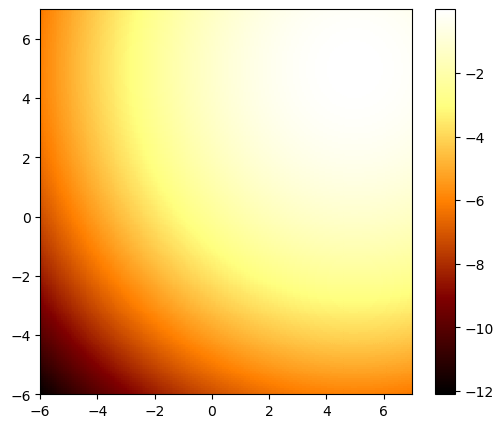

In [151]:
class Policy(nn.Module):
    def __init__(self, loc=[0., 0.]):
        super().__init__()
        self.loc = nn.Parameter(torch.tensor(loc))
        self.scale = torch.tensor([1., 1.])
        self.dist = torch.distributions.Normal(self.loc, self.scale)

    def sample(self, n_samples=1):
        return self.dist.sample([n_samples])

    def log_prob(self, x):
        return self.dist.log_prob(x).sum(1)


class Environment:
    def __init__(self, baseline=0.0, mode='square'):
        self.baseline = baseline
        self.mode = mode
        self._goal = torch.tensor([5., 5.])
    
    def reward(self, x):
        if self.mode == 'square':
            rewards = - 0.05 * (x - self._goal).square().sum(1)
        elif self.mode == 'hump':
            rewards = - 0.05 * (x - self._goal).square().sum(1)
            diff = x - torch.tensor([2., 2.])
            dist = 5 * ((diff @ torch.tensor([[1, 0.9], [0.9, 1]]) ) * diff).sum(1)
            rewards = rewards - torch.relu(-dist + 8.0)
            # rewards = torch.where(dist > 1, rewards, -6)
        elif self.mode == 'himmelblau':
            i, j = x.t()
            cost = (i.square() + j - 11).square() + (i + j.square() - 7).square()
            rewards = -cost.log()
        return rewards - self.baseline

    def plot_landscape(self):
        grid = torch.linspace(-6, 7, 200)
        x, y = torch.meshgrid(grid, grid, indexing='ij')
        x_coo, y_coo = x.flatten(), y.flatten()
        rewards = self.reward(torch.vstack([x_coo, y_coo]).t())

        fig, ax = plt.subplots(figsize=(6, 5))
        pc = ax.pcolor(x, y, rewards.reshape(*x.shape), cmap=plt.cm.afmhot)
        # ax.contour(x, y, rewards.reshape(*x.shape), colors='r', alpha=0.3)
        ax.set_xlim([-6, 7])
        ax.set_ylim([-6, 7])
        fig.colorbar(pc)
        return fig, ax

    def trajectory_plot(self, traces, samples, grad_steps, title=''):
        fig, ax = self.plot_landscape()
        fig.suptitle(title)
        loc = traces[-1]
        ax.plot(*torch.vstack(traces).t(), c='r', linewidth=0.8)
            
        ax.scatter(*samples.t(), s=10, marker='x')
        ax.scatter(*loc, c='c')

        for g in grad_steps:
            ax.arrow(*loc, *g, head_width=.1, head_length=.1, fc='green', ec='green')
            
        if self.mode == 'square' or self.mode == 'hump':
            ax.scatter(*self._goal, c='y')
            ax.text(*self._goal, "goal")
        plt.show()



pi = Policy()
env = Environment(mode='square')

x = pi.sample(3)
r = env.reward(x)

print(x)
print(r)
env.plot_landscape()

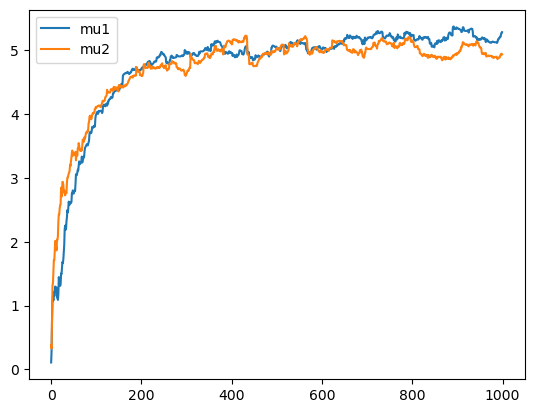

In [129]:
from collections import defaultdict

lr = 0.15
pi = Policy()
env = Environment(mode='square')

history = defaultdict(list)
for _ in range(1000):
    samples = pi.sample(3)
    log_prob = pi.log_prob(samples)
    rewards = env.reward(samples)

    obj = torch.mean(log_prob * rewards)
    obj.backward()
    pi.loc.data = pi.loc.data + lr * pi.loc.grad # gradient_ascent
    pi.zero_grad()

    history['mu'] += [pi.loc.detach()]
    history['reward'] += [rewards]
    

mu1, mu2 = torch.vstack(history['mu']).t()

plt.plot(mu1, label='mu1')
plt.plot(mu2, label='mu2')
plt.legend()
plt.show()

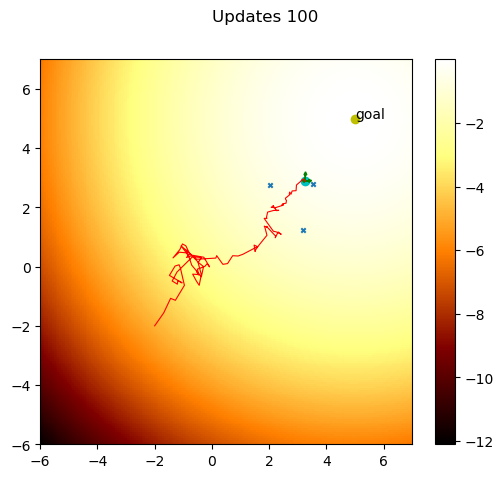

In [153]:
from IPython import display
import time

lr = 0.15
n_samples = 3
pi = Policy(loc=[-2., -2.])
env = Environment(mode='square')
# env = Environment(mode='hump')
# env = Environment(mode='himmelblau')


traces = []

for i in range(100):
    samples = pi.sample(n_samples)
    rewards = env.reward(samples)

    # step size
    grads = samples - pi.loc.detach()
    grad_steps = lr * grads * rewards[:, None]

    # plot
    traces.append(pi.loc.detach())
    if (i + 1) % 10 == 0:
        env.trajectory_plot(traces, samples, grad_steps, title=f'Updates {i+1}')
            
        time.sleep(0.1)
        display.clear_output(wait=True)
    
    # update
    pi.loc.data = pi.loc.data + torch.mean(grad_steps, dim=0)  #gradient_ascent


    

# Reparameterization Trick

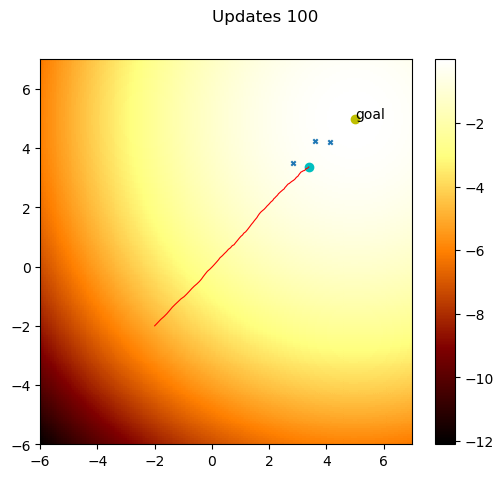

In [155]:
lr = 0.15
n_samples = 3
pi = Policy(loc=[-2., -2.])
env = Environment(mode='square')
# env = Environment(mode='hump')
# env = Environment(mode='himmelblau')


def reparam_sample(self, n_samples):
    return self.scale * torch.randn(n_samples, 2) + self.loc


traces = []
for i in range(100):
    samples = reparam_sample(pi, n_samples)
    rewards = env.reward(samples)
    obj = rewards.mean()

    # plot
    traces.append(pi.loc.detach())
    if (i + 1) % 10 == 0:
        env.trajectory_plot(traces, samples.detach(), [], title=f'Updates {i+1}')
            
        time.sleep(0.1)
        display.clear_output(wait=True)
    
    # update
    obj.backward()
    pi.loc.data = pi.loc.data + lr * pi.loc.grad # gradient_ascent
    pi.zero_grad()



